In [ ]:
%matplotlib inline


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [ ]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.

train_list = open("train_list.txt").readlines()
test_list = open("test_list.txt").readlines()

train_set1 = SubsetSC("training")
test_set1 = SubsetSC("testing")

train_set = list(train_set1[i-1] for i in list(map(int, train_list)))
test_set = list(test_set1[i-1] for i in list(map(int, test_list)))
print(len(train_set))
print(len(test_set))
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

12000
4000


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


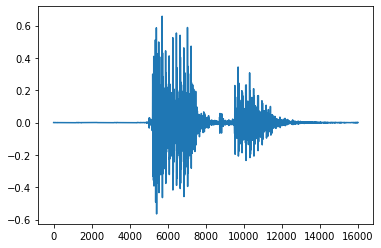

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels


['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, label,*_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)
label

16000

The last file is someone saying “visual”.




In [ ]:
waveform_last,sr,label ,*_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)
label

'zero'

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [ ]:
class M11(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=64):
        super().__init__()

        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=4)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding='same')
        self.bn2 = nn.BatchNorm1d(n_channel)
        # self.pool2 = nn.MaxPool1d(4,stride=None)
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding='same')
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool3 = nn.MaxPool1d(4,stride=None)
        self.conv4 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding='same')
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        # self.pool4 = nn.MaxPool1d(4,stride=None)
        self.conv5 = nn.Conv1d(2* n_channel, 2 * n_channel, kernel_size=3,padding='same')
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool5 = nn.MaxPool1d(4,stride=None)
        self.conv6 = nn.Conv1d(2*n_channel, 4 * n_channel, kernel_size=3,padding='same')
        self.bn6 = nn.BatchNorm1d(4 * n_channel)
        # self.pool6 = nn.MaxPool1d(4,stride=None)
        self.conv7 = nn.Conv1d(4*n_channel, 4 * n_channel, kernel_size=3,padding='same')
        self.bn7 = nn.BatchNorm1d(4 * n_channel)
        # self.pool7 = nn.MaxPool1d(4,stride=None)
        self.conv8 = nn.Conv1d(4*n_channel, 4 * n_channel, kernel_size=3,padding='same')
        self.bn8 = nn.BatchNorm1d(4 * n_channel)
        self.pool8 = nn.MaxPool1d(4,stride=None)
        self.conv9 = nn.Conv1d(4*n_channel, 8 * n_channel, kernel_size=3,padding='same')
        self.bn9 = nn.BatchNorm1d(8 * n_channel)
        # self.pool9 = nn.MaxPool1d(4,stride=None)
        self.conv10 = nn.Conv1d(8*n_channel, 8 * n_channel, kernel_size=3,padding='same')
        self.bn10 = nn.BatchNorm1d(8 * n_channel)
        self.pool10 = nn.MaxPool1d(4,stride=None)
        self.fc1 = nn.Linear(8 * n_channel, n_output)


    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        # print(x.shape)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        # x = self.pool2(x)
        # print(x.shape)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        # print(x.shape)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        # x = self.pool4(x)
        # print(x.shape)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)
        # print(x.shape)
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        # x = self.pool6(x)
        # print(x.shape)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        # x = self.pool7(x)
        # print(x.shape)
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = self.pool8(x)
        # print(x.shape)
        x = self.conv9(x)
        x = F.relu(self.bn9(x))
        # x = self.pool9(x)
        # print(x.shape)
        x = self.conv10(x)
        x = F.relu(self.bn10(x))
        x = self.pool10(x)
        # print(x.shape)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        return F.log_softmax(x, dim=2)


model = M11(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
# print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

Number of parameters: 1799267


We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.047619047619047616/20 [00:07<41:01, 123.39s/it]  

Train Epoch: 1 [0/12000 (0%)]	Loss: 3.787864


  2%|▏         | 0.38095238095238093/20 [00:08<01:44,  5.34s/it]

Train Epoch: 1 [5120/12000 (43%)]	Loss: 3.632548


  3%|▎         | 0.6984126984126977/20 [00:10<01:24,  4.36s/it]

Train Epoch: 1 [10240/12000 (85%)]	Loss: 3.603817


  5%|▌         | 1.015873015873014/20 [00:11<00:42,  2.22s/it] 


Test Epoch: 1	Accuracy: 159/4000 (4%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 3.498194


  7%|▋         | 1.3809523809523778/20 [00:12<01:16,  4.12s/it]

Train Epoch: 2 [5120/12000 (43%)]	Loss: 3.506662


  8%|▊         | 1.6984126984126942/20 [00:14<01:21,  4.46s/it]

Train Epoch: 2 [10240/12000 (85%)]	Loss: 3.416835


 10%|█         | 2.0158730158730105/20 [00:14<00:42,  2.37s/it]


Test Epoch: 2	Accuracy: 228/4000 (6%)

Train Epoch: 3 [0/12000 (0%)]	Loss: 3.232533


 12%|█▏        | 2.3809523809523743/20 [00:16<01:15,  4.30s/it]

Train Epoch: 3 [5120/12000 (43%)]	Loss: 3.018937


 13%|█▎        | 2.6984126984126906/20 [00:18<01:25,  4.96s/it]

Train Epoch: 3 [10240/12000 (85%)]	Loss: 2.777852


 15%|█▌        | 3.0317460317460228/20 [00:19<00:50,  2.96s/it]


Test Epoch: 3	Accuracy: 620/4000 (16%)

Train Epoch: 4 [0/12000 (0%)]	Loss: 2.679350


 17%|█▋        | 3.3809523809523707/20 [00:20<01:10,  4.26s/it]

Train Epoch: 4 [5120/12000 (43%)]	Loss: 2.424254


 18%|█▊        | 3.698412698412687/20 [00:21<01:12,  4.47s/it] 

Train Epoch: 4 [10240/12000 (85%)]	Loss: 2.173524


 20%|██        | 4.015873015873003/20 [00:22<00:35,  2.24s/it]


Test Epoch: 4	Accuracy: 1360/4000 (34%)

Train Epoch: 5 [0/12000 (0%)]	Loss: 2.048140


 22%|██▏       | 4.380952380952367/20 [00:24<01:07,  4.31s/it] 

Train Epoch: 5 [5120/12000 (43%)]	Loss: 2.125997


 23%|██▎       | 4.6984126984126835/20 [00:25<01:07,  4.44s/it]

Train Epoch: 5 [10240/12000 (85%)]	Loss: 1.845267


 25%|██▌       | 5.015873015873/20 [00:26<00:36,  2.43s/it]   


Test Epoch: 5	Accuracy: 1620/4000 (40%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 1.632569


 27%|██▋       | 5.380952380952364/20 [00:28<01:05,  4.51s/it]

Train Epoch: 6 [5120/12000 (43%)]	Loss: 1.713454


 28%|██▊       | 5.69841269841268/20 [00:29<01:03,  4.45s/it] 

Train Epoch: 6 [10240/12000 (85%)]	Loss: 1.611418


 30%|███       | 6.015873015872996/20 [00:30<00:31,  2.26s/it]


Test Epoch: 6	Accuracy: 1881/4000 (47%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 1.563534


 32%|███▏      | 6.38095238095236/20 [00:31<00:59,  4.33s/it] 

Train Epoch: 7 [5120/12000 (43%)]	Loss: 1.453172


 33%|███▎      | 6.666666666666645/20 [00:33<00:59,  4.46s/it]

Train Epoch: 7 [10240/12000 (85%)]	Loss: 1.423553


 35%|███▌      | 7.015873015872993/20 [00:34<00:30,  2.38s/it] 


Test Epoch: 7	Accuracy: 2103/4000 (53%)

Train Epoch: 8 [0/12000 (0%)]	Loss: 1.285007


 37%|███▋      | 7.365079365079341/20 [00:36<00:59,  4.69s/it]

Train Epoch: 8 [5120/12000 (43%)]	Loss: 1.271939


 38%|███▊      | 7.698412698412673/20 [00:37<00:54,  4.42s/it]

Train Epoch: 8 [10240/12000 (85%)]	Loss: 1.307308


 40%|████      | 8.01587301587299/20 [00:38<00:27,  2.28s/it] 


Test Epoch: 8	Accuracy: 2065/4000 (52%)

Train Epoch: 9 [0/12000 (0%)]	Loss: 1.258471


 42%|████▏     | 8.380952380952353/20 [00:39<00:52,  4.49s/it]

Train Epoch: 9 [5120/12000 (43%)]	Loss: 1.096238


 43%|████▎     | 8.69841269841267/20 [00:41<00:51,  4.52s/it] 

Train Epoch: 9 [10240/12000 (85%)]	Loss: 1.082678


 45%|████▌     | 9.015873015872986/20 [00:42<00:25,  2.28s/it]


Test Epoch: 9	Accuracy: 2231/4000 (56%)

Train Epoch: 10 [0/12000 (0%)]	Loss: 1.195469


 47%|████▋     | 9.38095238095235/20 [00:43<00:46,  4.39s/it] 

Train Epoch: 10 [5120/12000 (43%)]	Loss: 1.069087


 48%|████▊     | 9.698412698412666/20 [00:45<00:46,  4.51s/it]

Train Epoch: 10 [10240/12000 (85%)]	Loss: 1.257408


 50%|█████     | 10.015873015872982/20 [00:45<00:22,  2.28s/it]


Test Epoch: 10	Accuracy: 1989/4000 (50%)

Train Epoch: 11 [0/12000 (0%)]	Loss: 1.047881


 52%|█████▏    | 10.380952380952346/20 [00:47<00:42,  4.43s/it]

Train Epoch: 11 [5120/12000 (43%)]	Loss: 0.990267


 53%|█████▎    | 10.698412698412662/20 [00:48<00:42,  4.56s/it]

Train Epoch: 11 [10240/12000 (85%)]	Loss: 1.200344


 55%|█████▌    | 11.015873015872979/20 [00:49<00:20,  2.29s/it]


Test Epoch: 11	Accuracy: 2119/4000 (53%)

Train Epoch: 12 [0/12000 (0%)]	Loss: 0.886345


 57%|█████▋    | 11.380952380952342/20 [00:51<00:39,  4.53s/it]

Train Epoch: 12 [5120/12000 (43%)]	Loss: 0.857942


 58%|█████▊    | 11.698412698412659/20 [00:52<00:39,  4.70s/it]

Train Epoch: 12 [10240/12000 (85%)]	Loss: 0.870152


 60%|██████    | 12.015873015872975/20 [00:53<00:18,  2.35s/it]


Test Epoch: 12	Accuracy: 2554/4000 (64%)

Train Epoch: 13 [0/12000 (0%)]	Loss: 0.916180


 62%|██████▏   | 12.380952380952339/20 [00:55<00:33,  4.45s/it]

Train Epoch: 13 [5120/12000 (43%)]	Loss: 0.781509


 63%|██████▎   | 12.698412698412655/20 [00:56<00:33,  4.56s/it]

Train Epoch: 13 [10240/12000 (85%)]	Loss: 0.803492


 65%|██████▌   | 13.015873015872971/20 [00:57<00:16,  2.30s/it]


Test Epoch: 13	Accuracy: 2202/4000 (55%)

Train Epoch: 14 [0/12000 (0%)]	Loss: 0.868595


 67%|██████▋   | 13.380952380952335/20 [00:59<00:29,  4.46s/it]

Train Epoch: 14 [5120/12000 (43%)]	Loss: 0.758894


 68%|██████▊   | 13.698412698412652/20 [01:00<00:28,  4.56s/it]

Train Epoch: 14 [10240/12000 (85%)]	Loss: 0.803093


 70%|███████   | 14.015873015872968/20 [01:01<00:13,  2.29s/it]


Test Epoch: 14	Accuracy: 2214/4000 (55%)

Train Epoch: 15 [0/12000 (0%)]	Loss: 0.591108


 72%|███████▏  | 14.380952380952332/20 [01:02<00:24,  4.44s/it]

Train Epoch: 15 [5120/12000 (43%)]	Loss: 0.787990


 73%|███████▎  | 14.698412698412648/20 [01:04<00:24,  4.71s/it]

Train Epoch: 15 [10240/12000 (85%)]	Loss: 0.708989


 75%|███████▌  | 15.015873015872964/20 [01:05<00:12,  2.49s/it]


Test Epoch: 15	Accuracy: 2621/4000 (66%)

Train Epoch: 16 [0/12000 (0%)]	Loss: 0.643220


 77%|███████▋  | 15.380952380952328/20 [01:06<00:20,  4.49s/it]

Train Epoch: 16 [5120/12000 (43%)]	Loss: 0.724420


 78%|███████▊  | 15.698412698412644/20 [01:08<00:19,  4.59s/it]

Train Epoch: 16 [10240/12000 (85%)]	Loss: 0.675996


 80%|████████  | 16.015873015872963/20 [01:09<00:09,  2.32s/it]


Test Epoch: 16	Accuracy: 2041/4000 (51%)

Train Epoch: 17 [0/12000 (0%)]	Loss: 0.490713


 82%|████████▏ | 16.380952380952326/20 [01:10<00:16,  4.48s/it]

Train Epoch: 17 [5120/12000 (43%)]	Loss: 0.581828


 83%|████████▎ | 16.698412698412643/20 [01:12<00:15,  4.61s/it]

Train Epoch: 17 [10240/12000 (85%)]	Loss: 0.681737


 85%|████████▌ | 17.01587301587296/20 [01:13<00:06,  2.34s/it] 


Test Epoch: 17	Accuracy: 2773/4000 (69%)

Train Epoch: 18 [0/12000 (0%)]	Loss: 0.447148


 87%|████████▋ | 17.380952380952323/20 [01:14<00:11,  4.46s/it]

Train Epoch: 18 [5120/12000 (43%)]	Loss: 0.443426


 88%|████████▊ | 17.69841269841264/20 [01:16<00:10,  4.70s/it] 

Train Epoch: 18 [10240/12000 (85%)]	Loss: 0.635056


 90%|█████████ | 18.015873015872955/20 [01:17<00:04,  2.49s/it]


Test Epoch: 18	Accuracy: 1643/4000 (41%)

Train Epoch: 19 [0/12000 (0%)]	Loss: 0.512456


 92%|█████████▏| 18.38095238095232/20 [01:18<00:07,  4.36s/it]

Train Epoch: 19 [5120/12000 (43%)]	Loss: 0.469317


 93%|█████████▎| 18.698412698412636/20 [01:20<00:05,  4.55s/it]

Train Epoch: 19 [10240/12000 (85%)]	Loss: 0.761611


 95%|█████████▌| 19.015873015872952/20 [01:20<00:02,  2.30s/it]


Test Epoch: 19	Accuracy: 2686/4000 (67%)

Train Epoch: 20 [0/12000 (0%)]	Loss: 0.365840


 97%|█████████▋| 19.380952380952316/20 [01:22<00:02,  4.39s/it]

Train Epoch: 20 [5120/12000 (43%)]	Loss: 0.464260


 98%|█████████▊| 19.698412698412632/20 [01:23<00:01,  4.56s/it]

Train Epoch: 20 [10240/12000 (85%)]	Loss: 0.532075


100%|█████████▉| 19.999999999999932/20 [01:24<00:00,  4.23s/it]



Test Epoch: 20	Accuracy: 2768/4000 (69%)



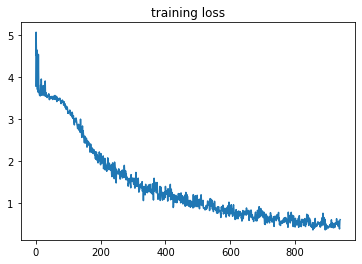

In [ ]:
log_interval = 20
n_epoch =20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #4. Expected: right. Predicted: one.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: three.


## Conclusion

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.




In [ ]:
def find_confusion_matrix(model)
  nb_classes = 35
  pred1=[]
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  p = np.zeros([35,35])
  with torch.no_grad():
      for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        for i in range(target.shape[0]):
          p[pred[i]][target[i]] += 1
  
  print(p)

find_confusion_matrix(model)

[[ 48.   3.   0. ...   0.   0.   0.]
 [  0.  63.  11. ...   0.   4.   0.]
 [  1.   2.  44. ...   0.   1.   0.]
 ...
 [  2.   0.   0. ...  46.   1.   1.]
 [  0.   0.   0. ...   0. 118.   0.]
 [  1.   1.   2. ...   2.  17. 146.]]


2768.0